In [1]:
import cv_detect as sg
import cv2 as cv
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

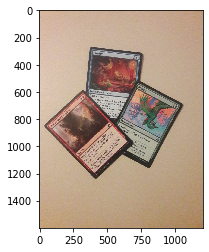

In [2]:
# load image in bgr-format
img_load = sg.load_image("../../images/cards.jpeg")
plt.imshow(img_load)

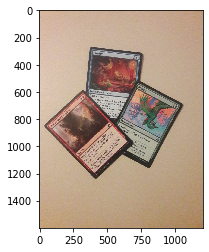

In [3]:
#whitening
img = img_load

img_white = sg.white_balance(img)
plt.imshow(img)

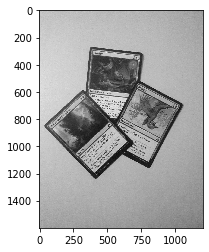

In [4]:
#greyscala
img = img_white

img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
plt.imshow(img_gray,cmap='gray')

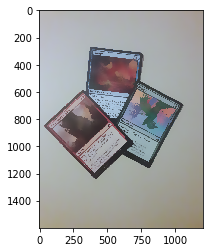

In [5]:
# Shiftfing
img = img_white

img_shifted = cv.pyrMeanShiftFiltering(img, 21, 51)
plt.imshow(img_shifted)

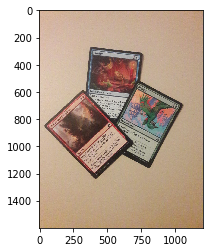

In [6]:
# normalize
img = img_load

img_normalize = img.copy()
cv.normalize(img, img_normalize, 0, 255, cv.NORM_MINMAX)
plt.imshow(img_normalize)

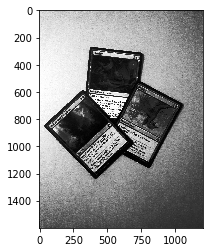

In [7]:
# Histogram
img = img_gray #önly one Color Chanel possible

img_hist = cv.equalizeHist(img)
plt.imshow(img_hist, cmap='gray')

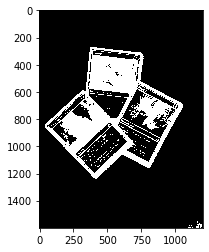

In [8]:
# threshold - alternativ sg.threshold_binary
img = img_gray

img_bin_inv = sg.threshold_binary_inverse(img)
plt.imshow(img_bin_inv, cmap='gray')

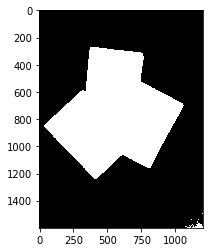

In [9]:
#fill holes
img = img_bin_inv

img_hole = sg.fill(img)
plt.imshow(img_hole, cmap='gray')

/home/harreal/anaconda3/envs/VisTut/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


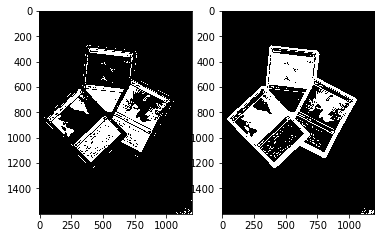

In [10]:
# invert image, but background remains black

img_1 = img_bin_inv
img_2 = img_hole

img_subtract = cv.subtract(np.uint8(img_2),np.uint8(img_1))

plt.subplot(122)
ax1 = plt.subplot(121)
im1 = ax1.imshow(img_subtract, cmap='gray')
ax2 = plt.subplot(122)
im2 = ax2.imshow(img_bin_inv, cmap='gray')
plt.show()

/home/harreal/anaconda3/envs/VisTut/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


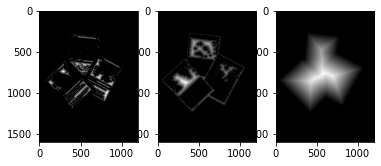

In [11]:
# Distance

# Poblem: Ein Cluster pro Karte nötig

img1 = img_subtract
img2 = img_bin_inv
img3 = img_hole

img_dist_sub = cv.distanceTransform(img_subtract, cv.DIST_L2, 3)
img_dist_bin_inv = cv.distanceTransform(img_bin_inv, cv.DIST_L2, 3)
img_dist_hole = cv.distanceTransform(img_hole, cv.DIST_L2, 3)


plt.subplot(133)
ax1 = plt.subplot(131)
im1 = ax1.imshow(img_dist_sub, cmap='gray')
ax2 = plt.subplot(132)
im2 = ax2.imshow(img_dist_bin_inv, cmap='gray')
ax2 = plt.subplot(133)
im2 = ax2.imshow(img_dist_hole, cmap='gray')
plt.show()



/home/harreal/anaconda3/envs/VisTut/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


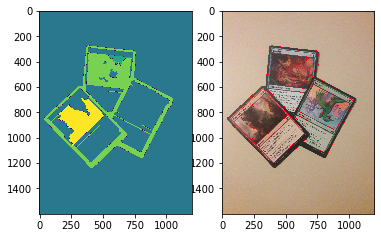

In [12]:
# https://docs.opencv.org/3.1.0/d3/db4/tutorial_py_watershed.html

img_end = img_load


thresh = img_bin_inv
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 2)

# sure background area
sure_bg = cv.dilate(opening,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
ret, sure_fg = cv.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg,sure_fg)

# Marker labelling
ret, markers = cv.connectedComponents(sure_fg)
 
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
 
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

markers = cv.watershed(img_end,markers)

img_end[markers == -1] = [255,0,0]


plt.subplot(122)
ax1 = plt.subplot(121)
im1 = ax1.imshow(markers)
ax2 = plt.subplot(122)
im2 = ax2.imshow(img_end)
plt.show()


In [13]:
# Tutorials Watershed

# https://docs.opencv.org/3.4/d2/dbd/tutorial_distance_transform.html
# https://www.pyimagesearch.com/2015/11/02/watershed-opencv/

/home/harreal/anaconda3/envs/VisTut/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


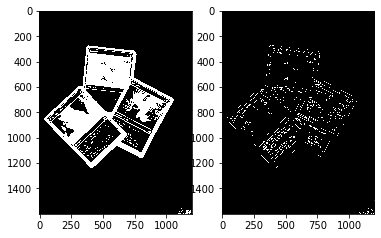

In [14]:
# Testen mit anderen Filterfunktionen


# https://docs.opencv.org/3.4/d2/dbd/tutorial_distance_transform.html

img = img_bin_inv

# Create a kernel that we will use to sharpen our image
# an approximation of second derivative, a quite strong kernel
kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]], dtype=np.float32)
# do the laplacian filtering as it is
# well, we need to convert everything in something more deeper then CV_8U
# because the kernel has some negative values,
# and we can expect in general to have a Laplacian image with negative values
# BUT a 8bits unsigned int (the one we are working with) can contain values from 0 to 255
# so the possible negative number will be truncated
imgLaplacian = cv.filter2D(img, cv.CV_32F, kernel)
sharp = np.float32(img)
imgFilter = sharp - imgLaplacian
# convert back to 8bits gray scale
imgFilter = np.clip(imgFilter, 0, 255)
img_filter = imgFilter.astype("uint8")
imgLaplacian = np.clip(imgLaplacian, 0, 255)
img_laplacian = np.uint8(imgLaplacian)
plt.imshow(img_filter, cmap='gray')

plt.subplot(122)
ax1 = plt.subplot(121)
im1 = ax1.imshow(img_filter, cmap='gray')
ax2 = plt.subplot(122)
im2 = ax2.imshow(img_laplacian, cmap='gray')
plt.show()